In [1]:
import os, glob, cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
%matplotlib inline

In [2]:
# 1. Încărcăm modelul antrenat
model_path = 'best.pt' 

if not os.path.exists(model_path):
    print("ATENȚIE: Nu am găsit best.pt în folderul curent!")
    # Fallback la modelul vechi doar de test
    if os.path.exists('ppe_training/yolo11_subset_run/weights/best.pt'):
        model_path = 'ppe_training/yolo11_subset_run/weights/best.pt'

print(f"Încarc modelul din: {model_path}")
model = YOLO(model_path)
print(f'Clase disponibile: {list(model.names.values())}')

Încarc modelul din: best.pt
Clase disponibile: ['glove', 'goggles', 'helmet', 'mask', 'no_glove', 'no_goggles', 'no_helmet', 'no_mask', 'no_shoes', 'shoes']


In [ ]:
# 2. Căutăm imagini pentru testare
# Folosim imaginile salvate special pentru repo (care conțin mănuși)
test_images = []
if os.path.exists('validation_samples'):
    print("Folosesc imagini din folderul 'validation_samples'...")
    test_images = glob.glob('validation_samples/*.jpg')

# Fallback: Dacă nu există folderul, căutăm în dataset (doar dacă există local)
if not test_images and os.path.exists('datasets/ppe_balanced/valid/labels'):
    valid_labels_path = 'datasets/ppe_balanced/valid/labels'
    valid_images_path = 'datasets/ppe_balanced/valid/images'
    
    label_files = glob.glob(os.path.join(valid_labels_path, '*.txt'))
    print(f"Caut imagini cu mănuși în {len(label_files)} fișiere...")

    for label_file in label_files:
        with open(label_file, 'r') as f:
            lines = f.readlines()
        
        has_glove = False
        for line in lines:
            if line.strip().startswith('0 '): # 0 este clasa pentru 'glove'
                has_glove = True
                break
        
        if has_glove:
            image_name = os.path.basename(label_file).replace('.txt', '.jpg')
            image_path = os.path.join(valid_images_path, image_name)
            if os.path.exists(image_path):
                test_images.append(image_path)
        
        if len(test_images) >= 5: # Luăm primele 5 găsite
            break

if not test_images:
    print("Nu am găsit imagini. Folosesc demo_images.")
    test_images = sorted(glob.glob('demo_images/*.jpg'))[:5]

print(f"Testez pe {len(test_images)} imagini.")

Caut imagini cu mănuși în 3570 fișiere...
Testez pe 5 imagini.



0: 384x640 2 gloves, 2 no_gloves, 28.5ms
1: 384x640 2 gloves, 2 no_gloves, 28.5ms
2: 384x640 2 gloves, 28.5ms
3: 384x640 3 gloves, 1 no_glove, 28.5ms
4: 384x640 3 gloves, 1 no_glove, 28.5ms
Speed: 4.2ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
0: 384x640 2 gloves, 2 no_gloves, 28.5ms
1: 384x640 2 gloves, 2 no_gloves, 28.5ms
2: 384x640 2 gloves, 28.5ms
3: 384x640 3 gloves, 1 no_glove, 28.5ms
4: 384x640 3 gloves, 1 no_glove, 28.5ms
Speed: 4.2ms preprocess, 28.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

--- Imagine: fglov1104_jpg.rf.d0be8aa361a694c73f1035574ba4f703.jpg ---
  Detectat: no_glove (0.73)
  Detectat: glove (0.69)
  Detectat: glove (0.65)
  Detectat: no_glove (0.43)

--- Imagine: fglov1104_jpg.rf.d0be8aa361a694c73f1035574ba4f703.jpg ---
  Detectat: no_glove (0.73)
  Detectat: glove (0.69)
  Detectat: glove (0.65)
  Detectat: no_glove (0.43)


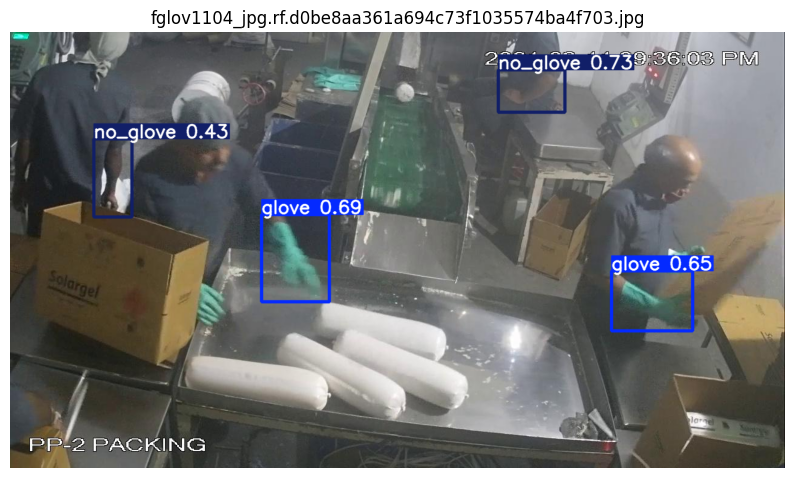


--- Imagine: fglov1108_jpg.rf.e9bfa2bf17ebe46692c2da4a050fb6f8.jpg ---
  Detectat: no_glove (0.73)
  Detectat: glove (0.73)
  Detectat: glove (0.65)
  Detectat: no_glove (0.18)


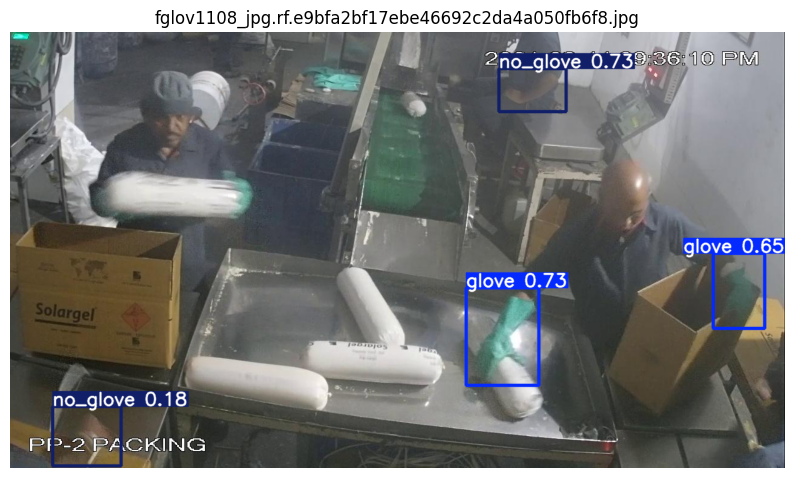


--- Imagine: fglov110_jpg.rf.0a66b8846b2602269bb9e1a615aefdbe.jpg ---
  Detectat: glove (0.78)
  Detectat: glove (0.66)


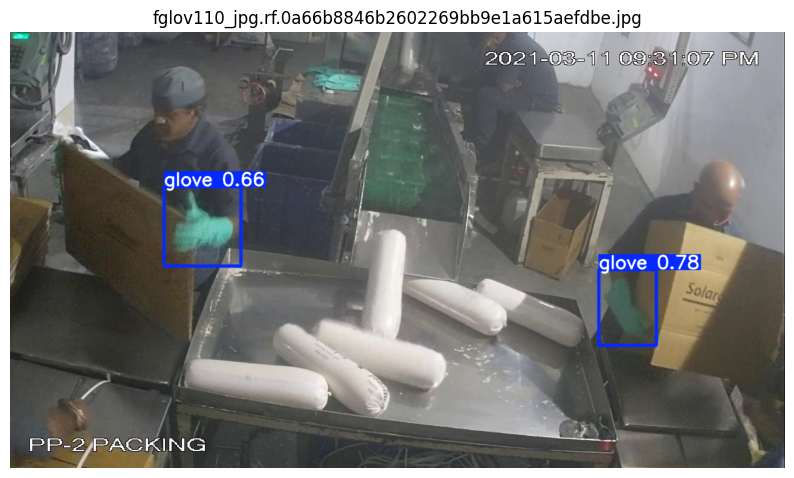


--- Imagine: fglov1123_jpg.rf.a6df655813c179ae0afaf5b973d78660.jpg ---
  Detectat: glove (0.73)
  Detectat: no_glove (0.67)
  Detectat: glove (0.59)
  Detectat: glove (0.58)


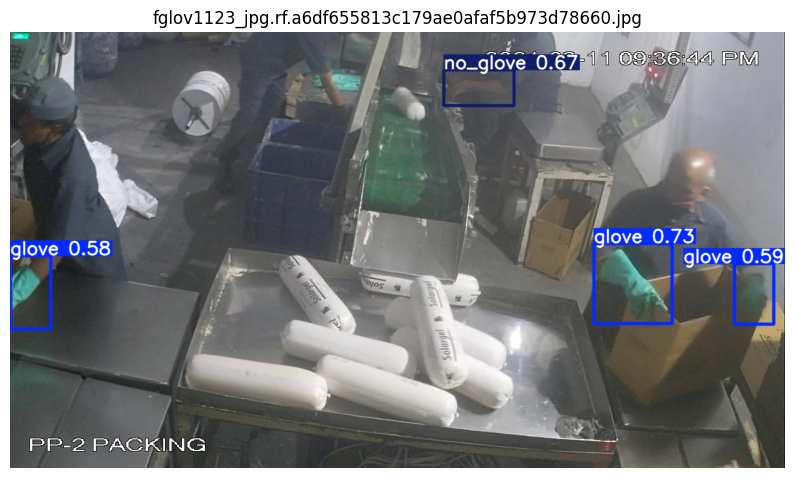


--- Imagine: fglov1126_jpg.rf.145005789ae661320d57b2610d1c34d0.jpg ---
  Detectat: glove (0.71)
  Detectat: glove (0.66)
  Detectat: no_glove (0.49)
  Detectat: glove (0.36)


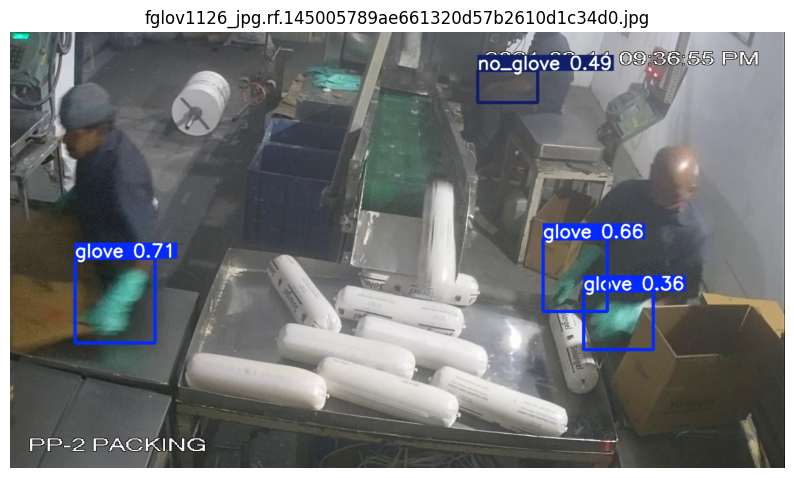

In [4]:
# 3. Rulăm predicția și afișăm rezultatele
# Folosim confidență mică (0.15) ca să fim siguri că vedem tot
results = model(test_images, conf=0.15) 

for i, r in enumerate(results):
    print(f'\n--- Imagine: {os.path.basename(test_images[i])} ---')
    # Afișăm text ce a găsit
    for box in r.boxes:
        cls_id = int(box.cls[0])
        cls_name = model.names[cls_id]
        conf = float(box.conf[0])
        print(f'  Detectat: {cls_name} ({conf:.2f})')
    
    # Afișăm poza
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(r.plot(), cv2.COLOR_BGR2RGB))
    plt.title(os.path.basename(test_images[i]))
    plt.axis('off')
    plt.show()